In [1]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, KNNBasic, KNNWithMeans, NMF
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder




In [2]:
# Load datasets
orders = pd.read_csv('data/Capstone/olist_orders_dataset.csv')
order_items = pd.read_csv('data/Capstone/olist_order_items_dataset.csv')
customers = pd.read_csv('data/Capstone/olist_customers_dataset.csv')
products = pd.read_csv('data/Capstone/olist_products_dataset.csv')
reviews = pd.read_csv('data/Capstone/olist_order_reviews_dataset.csv')
payments = pd.read_csv('data/Capstone/olist_order_payments_dataset.csv')
product_category = pd.read_csv('data/Capstone/product_category_name_translation.csv')

In [3]:
orders.info()
orders.head()
print(f"Total unique orders: {orders['order_id'].nunique():,}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
Total unique orders: 99,441


In [4]:
order_items.info()
order_items.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [7]:
customers.info()
customers.head()
print(f"Total unique customers: {customers['customer_id'].nunique():,}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
Total unique customers: 99,441


In [12]:
products.info()
products.head()
print(f"Total unique products: {products['product_id'].nunique():,}")
products.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB
Total unique products: 32,951


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [14]:
reviews.info()
reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [16]:
payments.info()
payments.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [18]:
product_category.info()
product_category.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
5,esporte_lazer,sports_leisure
6,perfumaria,perfumery
7,utilidades_domesticas,housewares
8,telefonia,telephony
9,relogios_presentes,watches_gifts


In [20]:
#Create a master dataframe

#Merge orders and customers
masterDF=orders.merge(customers, on='customer_id')

#Merge orders and order items
masterDF = masterDF.merge(order_items, on='order_id')

#Merge with order reviews
masterDF = masterDF.merge(reviews, on='order_id')

#Merge with payments
masterDF = masterDF.merge(payments, on='order_id')

#Merge with products using product ID
masterDF = masterDF.merge(products, on='product_id')

#Merge with products using product ID
masterDF = masterDF.merge(product_category, on='product_category_name')




In [22]:
masterDF.head()
masterDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115609 entries, 0 to 115608
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115609 non-null  object 
 1   customer_id                    115609 non-null  object 
 2   order_status                   115609 non-null  object 
 3   order_purchase_timestamp       115609 non-null  object 
 4   order_approved_at              115595 non-null  object 
 5   order_delivered_carrier_date   114414 non-null  object 
 6   order_delivered_customer_date  113209 non-null  object 
 7   order_estimated_delivery_date  115609 non-null  object 
 8   customer_unique_id             115609 non-null  object 
 9   customer_zip_code_prefix       115609 non-null  int64  
 10  customer_city                  115609 non-null  object 
 11  customer_state                 115609 non-null  object 
 12  order_item_id                 

**Exploratory data analysis**

In [25]:
print(f"Total unique customers: {masterDF['customer_unique_id'].nunique():,}")
print(f"Total unique orders: {masterDF['order_id'].nunique():,}")
print(f"Total unique products: {masterDF['product_id'].nunique():,}")

Total unique customers: 93,396
Total unique orders: 96,516
Total unique products: 32,171


In [27]:
missing_data = masterDF.isnull().sum()
missing_percent = (missing_data / len(masterDF)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Percentage': missing_percent
})
print(missing_df)


                               Missing_Count  Percentage
order_id                                   0    0.000000
customer_id                                0    0.000000
order_status                               0    0.000000
order_purchase_timestamp                   0    0.000000
order_approved_at                         14    0.012110
order_delivered_carrier_date            1195    1.033657
order_delivered_customer_date           2400    2.075963
order_estimated_delivery_date              0    0.000000
customer_unique_id                         0    0.000000
customer_zip_code_prefix                   0    0.000000
customer_city                              0    0.000000
customer_state                             0    0.000000
order_item_id                              0    0.000000
product_id                                 0    0.000000
seller_id                                  0    0.000000
shipping_limit_date                        0    0.000000
price                          

In [29]:
### 
masterDF['order_status'].unique()

array(['delivered', 'shipped', 'invoiced', 'processing', 'canceled',
       'unavailable', 'approved'], dtype=object)

review_score
1    14546
2     4020
3     9718
4    21951
5    65374
Name: count, dtype: int64

Average review score: 4.03
Median review score: 5.0


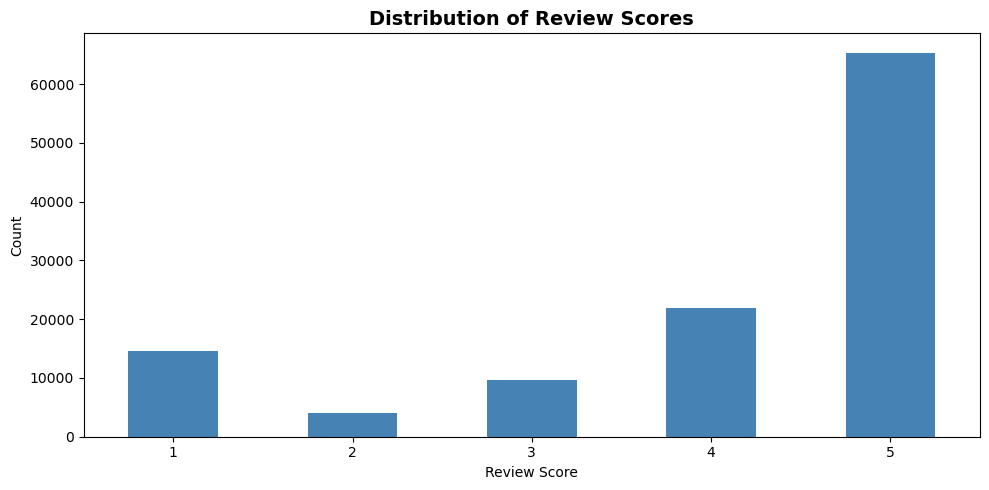

In [31]:
#Review score analysis

print(masterDF['review_score'].value_counts().sort_index())
print(f"\nAverage review score: {masterDF['review_score'].mean():.2f}")
print(f"Median review score: {masterDF['review_score'].median():.1f}")

# Visualize review distribution
plt.figure(figsize=(10, 5))
masterDF['review_score'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title('Distribution of Review Scores', fontsize=14, fontweight='bold')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

product_category_name_english
bed_bath_table           11847
health_beauty             9944
sports_leisure            8942
furniture_decor           8743
computers_accessories     8105
housewares                7331
watches_gifts             6161
telephony                 4692
garden_tools              4558
auto                      4356
Name: count, dtype: int64


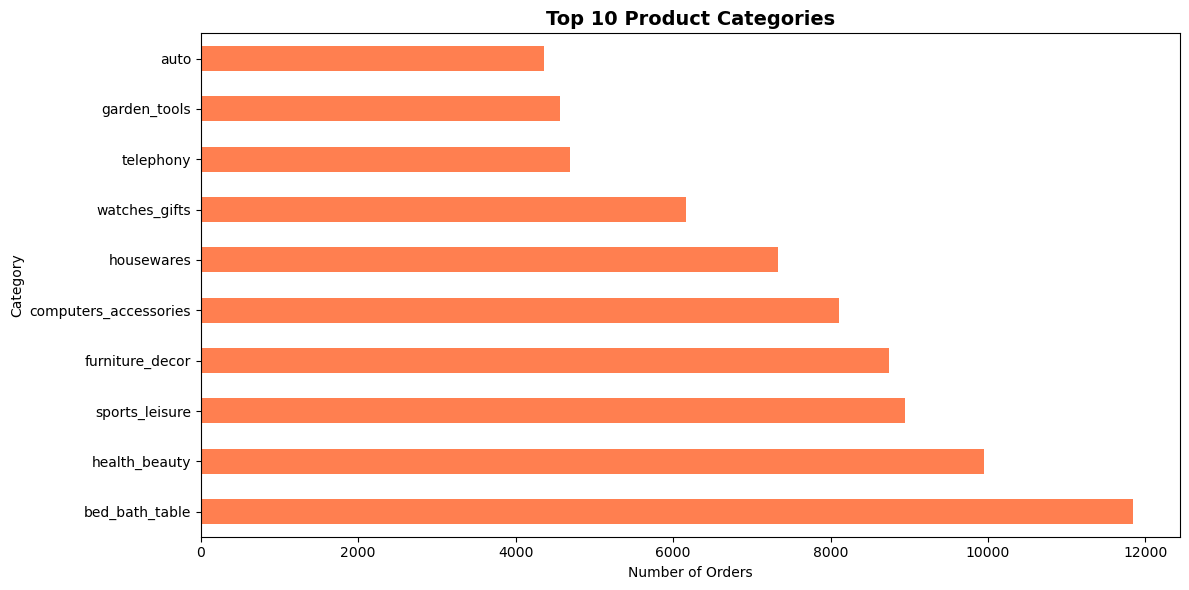

In [33]:
#product categories analysis

top_categories = masterDF['product_category_name_english'].value_counts().head(10)
print(top_categories)

# Visualize top categories
plt.figure(figsize=(12, 6))
top_categories.plot(kind='barh', color='coral')
plt.title('Top 10 Product Categories', fontsize=14, fontweight='bold')
plt.xlabel('Number of Orders')
plt.ylabel('Category')
plt.tight_layout()
plt.show()


In [35]:
#Item price analysis
print(f"Average item price: ${masterDF['price'].mean():.2f}")
print(f"Median item price: ${masterDF['price'].median():.2f}")
# print(f"Total revenue: ${masterDF['payment_value'].sum():,.2f}")

Average item price: $120.62
Median item price: $74.90


In [37]:
# Payment Type Analysis
print("Payment type distribution")
print("-"*30)
print(masterDF['payment_type'].value_counts())

# Order Status Distribution
print("Order status distribution")
print("-"*30)
print(masterDF['order_status'].value_counts())


Payment type distribution
------------------------------
payment_type
credit_card    85278
boleto         22510
voucher         6162
debit_card      1659
Name: count, dtype: int64
Order status distribution
------------------------------
order_status
delivered      113210
shipped          1138
canceled          536
invoiced          358
processing        357
unavailable         7
approved            3
Name: count, dtype: int64


**Insight**

Insight #1: Payment types reveals interesting information. In Brazil, a unique payment type called Boleto is very popular. 
Boleto is used typically by the under-banked or unbanked or those who prefer cash

Insight #2: 98% of orders in the dataset are in 'delivered' status. 
In data processing section, we will filter out orders of all other statuses for further analysisee

In [40]:
#order item analysis

# Calculate number of items per order
items_per_order = masterDF.groupby('order_id')['order_item_id'].count()

# Basic statistics
print("\nBasic Statistics:")
print(f"Average items per order: {items_per_order.mean():.2f}")
print(f"Median items per order: {items_per_order.median():.0f}")
print(f"Minimum items per order: {items_per_order.min()}")
print(f"Maximum items per order: {items_per_order.max()}")
print(f"Total orders: {len(items_per_order):,}")

# Distribution of items per order
print("\n Distribution of Items per Order:")
print(items_per_order.value_counts().sort_index().head(10))


# Additional insight: Orders with multiple items vs single item
single_item_orders = (items_per_order == 1).sum()
multi_item_orders = (items_per_order > 1).sum()

print("\n" + "="*70)
print("SINGLE vs MULTIPLE ITEM ORDERS")
print("="*70)
print(f"Single-item orders: {single_item_orders:,} ({(single_item_orders/len(items_per_order))*100:.2f}%)")
print(f"Multi-item orders: {multi_item_orders:,} ({(multi_item_orders/len(items_per_order))*100:.2f}%)")

# Insight #3:
# a. Most orders have single items (~87%) 
# b. The avg. basket size is 1.2


Basic Statistics:
Average items per order: 1.20
Median items per order: 1
Minimum items per order: 1
Maximum items per order: 63
Total orders: 96,516

 Distribution of Items per Order:
order_item_id
1     83927
2      9591
3      1503
4       804
5       241
6       274
7        46
8        39
9        12
10       15
Name: count, dtype: int64

SINGLE vs MULTIPLE ITEM ORDERS
Single-item orders: 83,927 (86.96%)
Multi-item orders: 12,589 (13.04%)



Basic Statistics:
Average order value: $206.49
Median order value: $109.91
Minimum order value: $9.59
Maximum order value: $109312.64

Number of Orders by Price Range:
  (0, 100]: 44,060 orders (45.65%)
  (100, 200]: 28,855 orders (29.90%)
  (200, 300]: 9,696 orders (10.05%)
  (300, 400]: 4,601 orders (4.77%)
  (400, 500]: 2,403 orders (2.49%)
  (500, 600]: 1,495 orders (1.55%)
  (600, 700]: 1,205 orders (1.25%)
  (700, 800]: 832 orders (0.86%)
  (800, 900]: 657 orders (0.68%)
  (900, 1000]: 424 orders (0.44%)
  (1000, 1100]: 342 orders (0.35%)
  (1100, 1200]: 249 orders (0.26%)
  (1200, 1300]: 218 orders (0.23%)
  (1300, 1400]: 190 orders (0.20%)
  (1400, 1500]: 147 orders (0.15%)
  (1500, 1600]: 109 orders (0.11%)
  (1600, 1700]: 117 orders (0.12%)
  (1700, 1800]: 76 orders (0.08%)
  (1800, 1900]: 83 orders (0.09%)
  (1900, 2000]: 74 orders (0.08%)


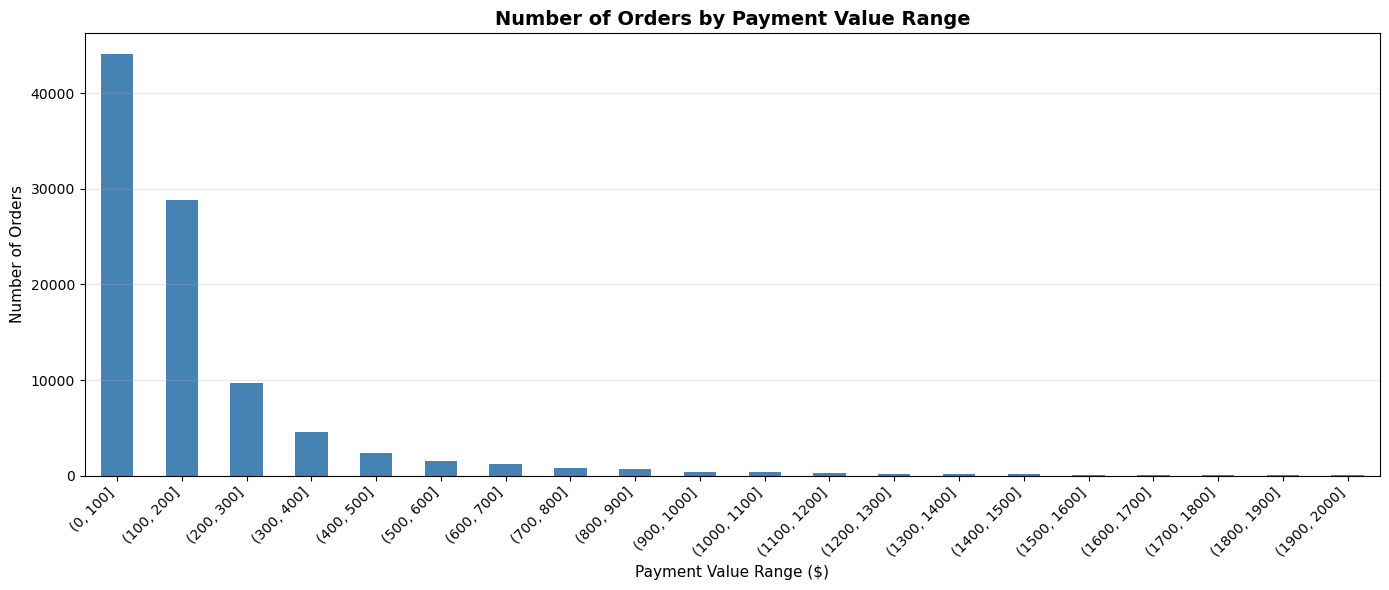


Cumulative Analysis:
  Up to (0, 100]: 45.65% of all orders
  Up to (100, 200]: 75.55% of all orders
  Up to (200, 300]: 85.59% of all orders
  Up to (300, 400]: 90.36% of all orders
  Up to (400, 500]: 92.85% of all orders
  Up to (500, 600]: 94.40% of all orders
  Up to (600, 700]: 95.65% of all orders
  Up to (700, 800]: 96.51% of all orders
  Up to (800, 900]: 97.19% of all orders
  Up to (900, 1000]: 97.63% of all orders


In [42]:
# Calculate total payment value per order
order_values = masterDF.groupby('order_id')['payment_value'].sum()

# Basic statistics
print("\nBasic Statistics:")
print(f"Average order value: ${order_values.mean():.2f}")
print(f"Median order value: ${order_values.median():.2f}")
print(f"Minimum order value: ${order_values.min():.2f}")
print(f"Maximum order value: ${order_values.max():.2f}")

# Create price bins: 0-100, 100-200, 200-300, etc.
bins = range(0, int(order_values.max()) + 100, 100)
labels = [f'${i}-${i+100}' for i in range(0, int(order_values.max()), 100)]

# Categorize orders into bins
order_values_binned = pd.cut(order_values, bins=bins)
bin_counts = order_values_binned.value_counts().sort_index()

# Print distribution
print("\nNumber of Orders by Price Range:")
for price_range, count in bin_counts.head(20).items():
    pct = (count / len(order_values)) * 100
    print(f"  {price_range}: {count:,} orders ({pct:.2f}%)")

# Create bar graph
plt.figure(figsize=(14, 6))
bin_counts.head(20).plot(kind='bar', color='steelblue')
plt.title('Number of Orders by Payment Value Range', fontsize=14, fontweight='bold')
plt.xlabel('Payment Value Range ($)', fontsize=11)
plt.ylabel('Number of Orders', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Show cumulative percentage
print("\nCumulative Analysis:")
cumulative_pct = (bin_counts.cumsum() / len(order_values)) * 100
for price_range, cum_pct in cumulative_pct.head(10).items():
    print(f"  Up to {price_range}: {cum_pct:.2f}% of all orders")

In [44]:
print(masterDF['order_status'].value_counts())

order_status
delivered      113210
shipped          1138
canceled          536
invoiced          358
processing        357
unavailable         7
approved            3
Name: count, dtype: int64


In [46]:
# Number of orders per customer
orders_per_customer = masterDF.groupby('customer_unique_id')['order_id'].nunique()

# To see the distribution
print(orders_per_customer.value_counts().sort_index())

# Or get statistics
print(f"Average orders per customer: {orders_per_customer.mean():.2f}")
print(f"Median orders per customer: {orders_per_customer.median():.0f}")
print(f"Max orders by single customer: {orders_per_customer.max()}")
print(f"Customers with only 1 order: {(orders_per_customer == 1).sum()}")
print(f"Customers with 2+ orders: {(orders_per_customer >= 2).sum()}")

# Observations
# 1. Most are one-time buyers (~97%). This is coupled with the fact (found above) that the avg. basket size is 1.2 implies
# collaborative filtering may not succeed much. We will primarily have to rely on content-filtering
# 2. Only 2807 repeat customers
# 3. This situation is akin to a cold-start problem wherein we will not be able to learn much from user preferences since most are one-time
# purchases

order_id
1     90589
2      2581
3       179
4        30
5         9
6         3
7         3
9         1
15        1
Name: count, dtype: int64
Average orders per customer: 1.03
Median orders per customer: 1
Max orders by single customer: 15
Customers with only 1 order: 90589
Customers with 2+ orders: 2807


**Data pre-processing**

In [49]:
#Since delivered orders comprise ~98% of order volume, we will include only 'delivered' orders in our analysis. Also, delivered orders are much stronger signal than other order
# statuses since users provide feedback typically for delivered orders only

masterDF_preprocess = masterDF[masterDF['order_status'] == 'delivered']
print(f"Total unique customers: {masterDF_preprocess['customer_unique_id'].nunique():,}")
print(f"Total unique orders: {masterDF_preprocess['order_id'].nunique():,}")
print(f"Total unique products: {masterDF_preprocess['product_id'].nunique():,}")

Total unique customers: 91,481
Total unique orders: 94,488
Total unique products: 31,481


**Recommendation Algorigthms**

In [52]:
# Approach 1: Content-based filtering
# Using product features to gauge similarity and recommending based on that

def build_simple_product_features(df):
    
    # Product features only
    product_features = df.groupby('product_id').agg({
        'product_category_name_english': 'first',  #picks the first value from multiple instances of each category
        'price': 'mean',
        'product_weight_g': 'first',
        'product_length_cm': 'first',
        'product_height_cm': 'first',
        'product_width_cm': 'first',
        'product_name_lenght': 'first',
        'product_description_lenght': 'first',
        'product_photos_qty': 'first',
        'review_score': 'mean',
        'order_id': 'count'
    }).rename(columns={'order_id': 'purchase_count'})
    
    # Handle missing values
    numeric_cols = ['product_weight_g', 'product_length_cm', 
                    'product_height_cm', 'product_width_cm']
    for col in numeric_cols:
        product_features[col].fillna(product_features[col].median(), inplace=True)
    
    return product_features


def create_simple_similarity_matrix(product_features):
    """
    Build product-to-product similarity using only product features
    """
    
    # Select numerical features
    feature_cols = [
        'price', 'product_weight_g', 'product_length_cm', 
        'product_height_cm', 'product_width_cm',
        'product_name_lenght', 'product_description_lenght', 
        'product_photos_qty', 'review_score', 'purchase_count'
    ]
    
    # One-hot encode category
    category_dummies = pd.get_dummies(product_features['product_category_name_english'], prefix='cat')
    
    # Combine features
    feature_matrix = pd.concat([
        product_features[feature_cols],
        category_dummies
    ], axis=1)
    
    # Normalize
    scaler = StandardScaler()
    feature_matrix_scaled = scaler.fit_transform(feature_matrix)
    
    # Compute cosine similarity
    similarity_matrix = cosine_similarity(feature_matrix_scaled)
    
    return similarity_matrix, feature_matrix.index.tolist()


def recommend_simple(product_id, product_features, similarity_matrix, 
                     product_ids, n_recommendations=10):
    """
    Recommend products based purely on product similarity
    No context, no location, no payment info
    """
    
    if product_id not in product_ids:
        return f"Product {product_id} not found in dataset"
    
    # Get similarity scores
    idx = product_ids.index(product_id)
    sim_scores = list(enumerate(similarity_matrix[idx]))
    
    # Sort by similarity
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Remove the product itself and get top N
    sim_scores = sim_scores[1:n_recommendations+1] #start index is 1 to remove the product itself
    
    # Get product indices and scores
    product_indices = [i[0] for i in sim_scores] #create list of all indices for the top N products
    recommended_products = [product_ids[i] for i in product_indices] #get the product IDs of top N products
    similarity_scores = [i[1] for i in sim_scores]  # get the similarity scores for those top N products
    
    # Build result dataframe
    recommendations = pd.DataFrame({
        'product_id': recommended_products,
        'similarity_score': similarity_scores
    })
    
    # Add product details
    recommendations = recommendations.merge(
        product_features[['product_category_name_english', 'price', 
                         'review_score', 'purchase_count']], 
        left_on='product_id', 
        right_index=True
    )
    
    return recommendations

## Sample example
# Build simple features
print("Building simple product features...")
product_features = build_simple_product_features(masterDF_preprocess)

# Create similarity matrix
print("Creating similarity matrix...")
similarity_matrix, product_ids = create_simple_similarity_matrix(product_features)

# Get recommendations
sample_product = product_features.index[20] #randomly selected product. One can put any number to get top N recommendations for that product
sample_category = product_features.loc[sample_product, 'product_category_name_english']
sample_price = product_features.loc[sample_product, 'price']

print(f"\nSample Product: {sample_product}")
print(f"Category: {sample_category}")
print(f"Price: ${sample_price:.2f}")
print(f"\nTop 10 Similar Products (Simple Content-Based):")
print("="*80)

recommendations = recommend_simple(
    product_id=sample_product,
    product_features=product_features,
    similarity_matrix=similarity_matrix,
    product_ids=product_ids,
    n_recommendations=10
)

print(recommendations)



Building simple product features...
Creating similarity matrix...


/var/folders/rr/bbv98h350csdhwdvs8mnl8p40000gn/T/ipykernel_23645/85145507.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  product_features[col].fillna(product_features[col].median(), inplace=True)



Sample Product: 002ec297b1b00fb9dde7ee6ac24b6771
Category: housewares
Price: $16.00

Top 10 Similar Products (Simple Content-Based):
                         product_id  similarity_score  \
0  ed47a454f5fbb920098724ccf04f86de          0.990561   
1  48c4ce43e9ae76b92039ed23beaca543          0.989677   
2  967ec52b0c55fe9ccde964df30cef64e          0.988252   
3  d20f41d8b70e59cb4c63d68b1dcfc0a4          0.987748   
4  1122726437ec94b92705d85be11b4019          0.987292   
5  56677610baf20ec5c96361f374b46153          0.983887   
6  b6bcda8f7c2501c62c8dc56a89da666e          0.983806   
7  018e4943e4cc9ed099f6fc1a7b65b07d          0.983366   
8  77f374d14bd53f0ed5f29613363973b2          0.982088   
9  5e18248fc768bdb7fc69fd012068d109          0.981867   

  product_category_name_english  price  review_score  purchase_count  
0                    housewares  22.90           5.0               1  
1                    housewares  46.90           5.0               1  
2                    hous

In [53]:
# Content based filtering: Approach 2: This adds shipping, payment information and geographical context to Approach 1

def build_product_features(df):
    """
    Create product feature matrix with contextualized attributes
    """
    
    # Basic product features (aggregated per product)
    product_features = df.groupby('product_id').agg({
        'product_category_name_english': 'first',
        'price': 'mean',
        'freight_value': 'mean',  # Average shipping cost
        'product_weight_g': 'first',
        'product_length_cm': 'first',
        'product_height_cm': 'first',
        'product_width_cm': 'first',
        'product_name_lenght': 'first',
        'product_description_lenght': 'first',
        'product_photos_qty': 'first',
        'review_score': 'mean',
        'payment_installments': 'mean',  # Average installments (affordability)
        'order_id': 'count'
    }).rename(columns={'order_id': 'purchase_count'})
    
    # Handle missing values (the 1 missing product dimension)
    numeric_cols = ['product_weight_g', 'product_length_cm', 
                    'product_height_cm', 'product_width_cm']
    for col in numeric_cols:
        product_features[col].fillna(product_features[col].median(), inplace=True)
    
    # Add state-level popularity (context-aware feature)
    # Count how many times each product was bought in each state
    state_popularity = df.groupby(['product_id', 'customer_state']).size().reset_index(name='state_count')
    state_popularity['state_popularity_rank'] = state_popularity.groupby('customer_state')['state_count'].rank(ascending=False, method='min')
    
    # Store state popularity separately for context-aware recommendations
    product_features['total_purchases'] = product_features['purchase_count']
    
    return product_features, state_popularity

In [54]:
#Approach 2 continues

def create_similarity_matrix(product_features):
    """
    Build product-to-product similarity using normalized features
    """
    
    # Select numerical features for similarity
    feature_cols = [
        'price', 'freight_value', 'product_weight_g', 
        'product_length_cm', 'product_height_cm', 'product_width_cm',
        'product_name_lenght', 'product_description_lenght', 
        'product_photos_qty', 'review_score', 'payment_installments',
        'purchase_count'
    ]
    
    # One-hot encode category
    category_dummies = pd.get_dummies(product_features['product_category_name_english'], prefix='cat')
    
    # Combine numerical and categorical features
    feature_matrix = pd.concat([
        product_features[feature_cols],
        category_dummies
    ], axis=1)
    
    # Normalize features (important for cosine similarity)
    scaler = StandardScaler()
    feature_matrix_scaled = scaler.fit_transform(feature_matrix)
    
    # Compute cosine similarity
    similarity_matrix = cosine_similarity(feature_matrix_scaled)
    
    return similarity_matrix, feature_matrix.index.tolist()



def recommend_products(product_id, customer_state, product_features, state_popularity, 
                       similarity_matrix, product_ids, n_recommendations=10):
    """
    Recommend products based on:
    1. Product similarity (content-based)
    2. Regional/state popularity (context-aware)
    3. Shipping costs
    """
    
    if product_id not in product_ids:
        return f"Product {product_id} not found in dataset"
    
    # Get similarity scores
    idx = product_ids.index(product_id)
    sim_scores = list(enumerate(similarity_matrix[idx]))
    
    # Sort by similarity (descending)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Remove the product itself (index 0 is itself with similarity 1.0)
    sim_scores = sim_scores[1:n_recommendations*3]  # Get more candidates for filtering
    
    # Get candidate product indices and scores
    candidate_indices = [i[0] for i in sim_scores]
    candidate_products = [product_ids[i] for i in candidate_indices]
    similarity_scores = [i[1] for i in sim_scores]
    
    # Build recommendation dataframe
    recommendations = pd.DataFrame({
        'product_id': candidate_products,
        'similarity_score': similarity_scores
    })
    
    # Add product details
    recommendations = recommendations.merge(
        product_features[['product_category_name_english', 'price', 'freight_value', 
                         'review_score', 'purchase_count']], 
        left_on='product_id', 
        right_index=True
    )
    
    # Add state popularity boost (context-aware)
    state_pop = state_popularity[state_popularity['customer_state'] == customer_state]
    recommendations = recommendations.merge(
        state_pop[['product_id', 'state_count', 'state_popularity_rank']], 
        on='product_id', 
        how='left'
    )
    recommendations['state_count'].fillna(0, inplace=True)
    recommendations['state_popularity_rank'].fillna(999, inplace=True)
    
    # Calculate final score (weighted combination). Weights are a guess and can be iterated to find the optimal mix
    recommendations['context_score'] = (
        0.5 * recommendations['similarity_score'] +           # Product similarity
        0.2 * (recommendations['state_count'] / recommendations['state_count'].max()) +  # State popularity
        0.15 * (recommendations['review_score'] / 5.0) +      # Quality
        0.15 * (1 - recommendations['freight_value'] / recommendations['freight_value'].max())  # Low freight is better
    )
    
    # Sort by context score and return top N
    recommendations = recommendations.sort_values('context_score', ascending=False).head(n_recommendations)
    
    return recommendations[['product_id', 'product_category_name_english', 'price', 
                           'similarity_score', 'context_score', 'review_score', 
                           'state_count', 'freight_value']]


In [58]:
# Build features
print("Building product features...")
product_features, state_popularity = build_product_features(masterDF)

# Create similarity matrix
print("Creating similarity matrix...")
similarity_matrix, product_ids = create_similarity_matrix(product_features)

# Get recommendations for a product
sample_product = product_features.index[20]  # Pick first product
sample_state = 'SP'  # São Paulo

# Get sample product details
sample_category = product_features.loc[sample_product, 'product_category_name_english']
sample_price = product_features.loc[sample_product, 'price']

print(f"\nSample Product: {sample_product}")
print(f"Category: {sample_category}")
print(f"Price: ${sample_price:.2f}")
print(f"\nRecommending similar products for customer in {sample_state}:")
print("="*80)

recommendations = recommend_products(
    product_id=sample_product,
    customer_state=sample_state,
    product_features=product_features,
    state_popularity=state_popularity,
    similarity_matrix=similarity_matrix,
    product_ids=product_ids,
    n_recommendations=10
)

print(recommendations)

Building product features...
Creating similarity matrix...


/var/folders/rr/bbv98h350csdhwdvs8mnl8p40000gn/T/ipykernel_23645/3090557092.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  product_features[col].fillna(product_features[col].median(), inplace=True)



Sample Product: 002ec297b1b00fb9dde7ee6ac24b6771
Category: housewares
Price: $16.00

Recommending similar products for customer in SP:
                          product_id product_category_name_english  price  \
19  1f67ce45ef6e16a7f2f56674dabd5f40                    housewares  57.90   
4   b6bcda8f7c2501c62c8dc56a89da666e                    housewares  31.90   
5   5e18248fc768bdb7fc69fd012068d109                    housewares  24.90   
13  29c5f56bdaf7929e981f654f1a2f79ec                    housewares  49.90   
6   b988dcec4901f325d06b162e02b3c5d6                    housewares  46.90   
21  47e7c7fb5d7ab1b726e49c74693a0e69                    housewares  37.90   
26  8e5df2342ebb6cbf946991fd829a2c37                    housewares  18.76   
10  2abf28861922ed5da75726c7f3eb58f4                    housewares  39.90   
16  776c13784f928afbe46070ae0151cf01                    housewares  21.90   
2   1122726437ec94b92705d85be11b4019                    housewares  34.50   

    similarity_s

/var/folders/rr/bbv98h350csdhwdvs8mnl8p40000gn/T/ipykernel_23645/1282501280.py:85: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  recommendations['state_count'].fillna(0, inplace=True)
/var/folders/rr/bbv98h350csdhwdvs8mnl8p40000gn/T/ipykernel_23645/1282501280.py:86: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

In [59]:
###### Approach 3: Collaborative filtering approach

def prepare_surprise_data(df):
    """
    Prepare data in format required by Surprise library
    Need: user_id, item_id, rating
    """
    
    # Create user-item-rating dataset
    # Using: customer_unique_id, product_id, review_score
    surprise_data = df[['customer_unique_id', 'product_id', 'review_score']].copy()
    
    # Remove duplicates (if user bought same product multiple times, take average rating)
    surprise_data = surprise_data.groupby(['customer_unique_id', 'product_id'])['review_score'].mean().reset_index()
    
    print(f"Total interactions: {len(surprise_data)}")
    print(f"Unique users: {surprise_data['customer_unique_id'].nunique()}")
    print(f"Unique products: {surprise_data['product_id'].nunique()}")
    
    # Define the rating scale
    reader = Reader(rating_scale=(1, 5))
    
    # Load data into Surprise format
    data = Dataset.load_from_df(surprise_data, reader)
    
    return data, surprise_data


# data, surprise_data = prepare_surprise_data(masterDF_preprocess)


def split_data(data, test_size=0.2, random_state=42):
    """
    Split data into train and test sets
    """
    trainset, testset = train_test_split(data, test_size=test_size, random_state=random_state)
    
    print(f"\nTrain set size: {trainset.n_ratings}")
    print(f"Test set size: {len(testset)}")
    
    return trainset, testset

def train_cf_algorithms(trainset, testset):
    """
    Train and evaluate multiple collaborative filtering algorithms
    """
    
    algorithms = {
        'SVD': SVD(n_factors=50, n_epochs=20, random_state=42),
        'NMF': NMF(n_factors=50, n_epochs=50, random_state=42),
        'User-Based CF': KNNBasic(k=40, sim_options={'name': 'cosine', 'user_based': True}),
        'Item-Based CF': KNNBasic(k=40, sim_options={'name': 'cosine', 'user_based': False}),
    }
    
    results = {}
    trained_models = {}
    
    print("\n" + "="*80)
    print("TRAINING AND EVALUATING COLLABORATIVE FILTERING ALGORITHMS")
    print("="*80)
    
    for name, algo in algorithms.items():
        print(f"\n{name}:")
        print("-" * 40)
        
        # Train
        algo.fit(trainset)
        
        # Predict on test set
        predictions = algo.test(testset)
        
        # Calculate metrics
        rmse = accuracy.rmse(predictions, verbose=False)
        mae = accuracy.mae(predictions, verbose=False)
        
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE:  {mae:.4f}")
        
        results[name] = {
            'RMSE': rmse,
            'MAE': mae,
            'predictions': predictions
        }
        
        trained_models[name] = algo
    
    return trained_models, results


def cross_validate_algorithms(data):
    """
    Perform 3-fold cross-validation on all algorithms
    More robust evaluation than single train-test split
    """
    
    algorithms = {
        'SVD': SVD(n_factors=50, n_epochs=20, random_state=42),
        'NMF': NMF(n_factors=50, n_epochs=50, random_state=42),
        'Item-Based CF': KNNBasic(k=40, sim_options={'name': 'cosine', 'user_based': False})
    }
    
    print("\n" + "="*80)
    print("3-FOLD CROSS-VALIDATION")
    print("="*80)
    
    cv_results = {}
    
    for name, algo in algorithms.items():
        print(f"\n{name}:")
        print("-" * 40)
        
        cv_result = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
        
        print(f"RMSE: {cv_result['test_rmse'].mean():.4f} (+/- {cv_result['test_rmse'].std():.4f})")
        print(f"MAE:  {cv_result['test_mae'].mean():.4f} (+/- {cv_result['test_mae'].std():.4f})")
        
        cv_results[name] = cv_result
    
    return cv_results


# def grid_search_cv(data):  ##Grid search is resulting in kernel dead error possibly due to computational overload. Hence, de-prioritized
#     """
#     Perform Grid Search with Cross-Validation to find best hyperparameters
#     """
#     from surprise.model_selection import GridSearchCV
    
#     print("\n" + "="*80)
#     print("GRID SEARCH WITH CROSS-VALIDATION")
#     print("="*80)
    
#     best_models = {}
    
#     # ========== SVD Grid Search ==========
#     print("\n1. SVD - Tuning n_factors and n_epochs")
#     print("-" * 40)
    
#     param_grid_svd = {
#         'n_factors': [20, 50, 100],
#         'n_epochs': [10, 20, 30],
#         'lr_all': [0.005, 0.01],
#         'reg_all': [0.02, 0.1]
#     }
    
#     gs_svd = GridSearchCV(SVD, param_grid_svd, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
#     gs_svd.fit(data)
    
#     print(f"Best RMSE: {gs_svd.best_score['rmse']:.4f}")
#     print(f"Best params: {gs_svd.best_params['rmse']}")
    
#     best_models['SVD'] = gs_svd.best_estimator['rmse']
    
#     # ========== NMF Grid Search ==========
#     print("\n2. NMF - Tuning n_factors and n_epochs")
#     print("-" * 40)
    
#     param_grid_nmf = {
#         'n_factors': [20, 50, 100],
#         'n_epochs': [30, 50, 70],
#         'reg_pu': [0.06, 0.1],
#         'reg_qi': [0.06, 0.1]
#     }
    
#     gs_nmf = GridSearchCV(NMF, param_grid_nmf, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
#     gs_nmf.fit(data)
    
#     print(f"Best RMSE: {gs_nmf.best_score['rmse']:.4f}")
#     print(f"Best params: {gs_nmf.best_params['rmse']}")
    
#     best_models['NMF'] = gs_nmf.best_estimator['rmse']
    
#     # ========== KNN Grid Search ==========
#     print("\n3. Item-Based CF - Tuning k and similarity metric")
#     print("-" * 40)
    
#     param_grid_knn = {
#         'k': [20, 30, 40, 50],
#         'sim_options': {
#             'name': ['cosine', 'pearson', 'msd'],
#             'user_based': [False]  # Item-based
#         }
#     }
    
#     gs_knn = GridSearchCV(KNNBasic, param_grid_knn, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
#     gs_knn.fit(data)
    
#     print(f"Best RMSE: {gs_knn.best_score['rmse']:.4f}")
#     print(f"Best params: {gs_knn.best_params['rmse']}")
    
#     best_models['Item-Based CF'] = gs_knn.best_estimator['rmse']
    
#     print("\n" + "="*80)
#     print("GRID SEARCH COMPLETE - Best models saved!")
#     print("="*80)
    
     # return best_models





In [62]:
# Approach 3 continues

def get_top_n_recommendations(predictions, n=10):
    """
    Return top N recommendations for each user from predictions
    """
    
    # Map predictions to each user
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    
    # Sort predictions for each user and get top N
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

def recommend_for_user(user_id, model, trainset, surprise_data, n=10):
    """
    Get top N product recommendations for a specific user
    """
    
    # Get all products
    all_products = surprise_data['product_id'].unique()
    
    # Get products the user has already rated
    user_products = surprise_data[surprise_data['customer_unique_id'] == user_id]['product_id'].values
    
    # Products to predict (exclude already rated)
    products_to_predict = [p for p in all_products if p not in user_products]
    
    # Make predictions
    predictions = []
    for product_id in products_to_predict:
        pred = model.predict(user_id, product_id)
        predictions.append((product_id, pred.est))
    
    # Sort by predicted rating
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Return top N
    top_recommendations = predictions[:n]
    
    return top_recommendations



In [64]:
# Approach 3 continues

def calculate_precision_recall(predictions, threshold=4.0):
    """
    Precision and Recall calculation
    Precision: Of all high predictions (>=threshold), how many were actually high?
    Recall: Of all actually high ratings, how many did we predict high?
    """
    
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0
    
    for uid, iid, true_r, est, _ in predictions:
        # Consider rating >= threshold as "positive" (relevant)
        actual_positive = true_r >= threshold
        predicted_positive = est >= threshold
        
        if predicted_positive and actual_positive:
            true_positives += 1
        elif predicted_positive and not actual_positive:
            false_positives += 1
        elif not predicted_positive and actual_positive:
            false_negatives += 1
        else:
            true_negatives += 1
    
    # Calculate metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (true_positives + true_negatives) / len(predictions)
    
    return precision, recall, f1_score, accuracy


def evaluate_model_quality(results):
    """
    Calculate precision, recall, F1, and accuracy for all models
    """
    
    print("\n" + "="*80)
    print("CLASSIFICATION METRICS (Threshold = 4.0 for 'Good' ratings)")
    print("="*80)
    
    metrics_summary = []
    
    for name, result in results.items():
        predictions = result['predictions']
        precision, recall, f1, accuracy = calculate_precision_recall(predictions)
        
        print(f"\n{name}:")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-Score:  {f1:.4f}")
        print(f"  Accuracy:  {accuracy:.4f}")
        
        metrics_summary.append({
            'Algorithm': name,
            'RMSE': result['RMSE'],
            'MAE': result['MAE'],
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Accuracy': accuracy
        })
    
    # Create summary dataframe
    summary_df = pd.DataFrame(metrics_summary)
    
    print("\n" + "="*80)
    print("SUMMARY - ALL ALGORITHMS")
    print("="*80)
    print(summary_df.to_string(index=False))
    
    return summary_df



In [66]:
#Approach 3 continues

print("COLLABORATIVE FILTERING WITH SURPRISE LIBRARY")
print("="*50)


# Step 1: Prepare data
print("\nStep 1: Preparing data...")
data, surprise_data = prepare_surprise_data(masterDF_preprocess)

# Step 2: Train-test split
print("\nStep 2: Splitting data...")
trainset, testset = split_data(data, test_size=0.2)

# Step 3: Train and evaluate algorithms
print("\nStep 3: Training algorithms...")
trained_models, results = train_cf_algorithms(trainset, testset)

# # Step 4: Calculate precision and recall
# evaluate_model_quality(results)

# # Step 5: Cross-validation (optional but recommended)
# print("\n" + "="*50)
# print("Running cross-validation for robust evaluation...")
# cv_results = cross_validate_algorithms(data)

# # Step 6: Grid Search CV to find best hyperparameters
# print("\n" + "="*50)
# print("Running Grid Search to optimize hyperparameters...")
# print("This may take a few minutes...")
# best_models = grid_search_cv(data)

# Step 7: Example - Get recommendations for a specific user
print("\n" + "="*50)
print("EXAMPLE: GET RECOMMENDATIONS FOR A USER")
print("="*50)

# Pick a user who has purchased something
sample_user = surprise_data['customer_unique_id'].iloc[0]
print(f"\nGetting recommendations for user: {sample_user}")

# Use best model 
best_model = trained_models['SVD']

# Get user's purchase history
user_history = surprise_data[surprise_data['customer_unique_id'] == sample_user][['product_id', 'review_score']]
print(f"\nUser's purchase history:")
print(user_history)

# Get recommendations
recommendations = recommend_for_user(sample_user, best_model, trainset, surprise_data, n=10)
print(f"\nTop 10 Recommended Products:")
for i, (product_id, predicted_rating) in enumerate(recommendations, 1):
    print(f"{i}. Product: {product_id}, Predicted Rating: {predicted_rating:.2f}")

print("Collaborative Filtering Complete!")
print("Best performing algorithm: Check RMSE/MAE scores above")

COLLABORATIVE FILTERING WITH SURPRISE LIBRARY

Step 1: Preparing data...
Total interactions: 97689
Unique users: 91481
Unique products: 31481

Step 2: Splitting data...

Train set size: 78151
Test set size: 19538

Step 3: Training algorithms...

TRAINING AND EVALUATING COLLABORATIVE FILTERING ALGORITHMS

SVD:
----------------------------------------
RMSE: 1.2824
MAE:  1.0026

NMF:
----------------------------------------
RMSE: 1.2571
MAE:  0.9643

User-Based CF:
----------------------------------------
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3084
MAE:  1.0198

Item-Based CF:
----------------------------------------
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2942
MAE:  1.0050

EXAMPLE: GET RECOMMENDATIONS FOR A USER

Getting recommendations for user: 0000366f3b9a7992bf8c76cfdf3221e2

User's purchase history:
                         product_id  review_score
0  372645c7439f9661fbbacfd129aa92ec           

In [68]:
## Approach 4: Popularity based recommendation: (Most Purchased + Highest Rated)

def build_popularity_recommender(df):
    """
    Build popularity-based recommendations
    """
    
    # Aggregate product statistics
    product_stats = df.groupby('product_id').agg({
        'order_id': 'count',  # Number of purchases
        'review_score': 'mean',  # Average rating
        'product_category_name_english': 'first',
        'price': 'mean'
    }).rename(columns={'order_id': 'purchase_count'})
    
    # Calculate popularity score (weighted: 70% purchases, 30% rating). Weights are a guess and can be optimized
    max_purchases = product_stats['purchase_count'].max()
    product_stats['popularity_score'] = (
        0.7 * (product_stats['purchase_count'] / max_purchases) +
        0.3 * (product_stats['review_score'] / 5.0)
    )
    
    # Sort by popularity
    product_stats = product_stats.sort_values('popularity_score', ascending=False)
    
    return product_stats

def recommend_popular_global(product_stats, n=10):
    """
    Recommend top N most popular products globally
    """
    top_products = product_stats.head(n)
    
    return top_products[['product_category_name_english', 'purchase_count', 
                         'review_score', 'popularity_score', 'price']]


def recommend_popular_by_category(product_stats, category, n=10):
    """
    Recommend top N most popular products in a specific category
    """
    category_products = product_stats[
        product_stats['product_category_name_english'] == category
    ]
    
    top_products = category_products.head(n)
    
    return top_products[['product_category_name_english', 'purchase_count', 
                         'review_score', 'popularity_score', 'price']]


##Test

print("\nBuilding popularity-based recommender...")
product_stats = build_popularity_recommender(masterDF_preprocess)

print(f"Total products analyzed: {len(product_stats)}")

# Global Top 10
print("\n" + "="*80)
print("TOP 10 MOST POPULAR PRODUCTS (GLOBAL)")
print("="*80)
global_top_10 = recommend_popular_global(product_stats, n=10)
print(global_top_10.to_string())

# Category-specific (example: bed_bath_table)
print("\n" + "="*80)
print("TOP 10 MOST POPULAR PRODUCTS IN 'bed_bath_table' CATEGORY")
print("="*80)
category_top_10 = recommend_popular_by_category(product_stats, 'bed_bath_table', n=10)
print(category_top_10.to_string())

# Show popularity distribution
print("\n" + "="*80)
print("POPULARITY STATISTICS")
print("="*80)
print(f"Average purchases per product: {product_stats['purchase_count'].mean():.2f}")
print(f"Median purchases per product: {product_stats['purchase_count'].median():.0f}")
print(f"Top 10% products account for {(product_stats.head(int(len(product_stats)*0.1))['purchase_count'].sum() / product_stats['purchase_count'].sum() * 100):.1f}% of all purchases")

print("Popularity-Based Recommender Complete!")



Building popularity-based recommender...
Total products analyzed: 31481

TOP 10 MOST POPULAR PRODUCTS (GLOBAL)
                                 product_category_name_english  purchase_count  review_score  popularity_score       price
product_id                                                                                                                
aca2eb7d00ea1a7b8ebd4e68314663af               furniture_decor             526      4.049430          0.942966   71.337833
99a4788cb24856965c36a24e339b6058                bed_bath_table             507      3.936884          0.910928   88.167179
422879e10f46682990de24d770e7f83d                  garden_tools             507      3.927022          0.910336   54.827850
389d119b48cf3043d311335e499d9c6b                  garden_tools             402      4.129353          0.782742   54.660672
368c6c730842d78016ad823897a372db                  garden_tools             395      3.908861          0.760197   54.287089
53759a2ecddad2bb87a079a1f15

In [74]:
# Approach 5: market-basket analysis based recommendation
#### This approach explores "products frequently bought together" - type recommendation.
## It uses mlxtrend library. I found this approach after google search
## This analysis is also called 'market basket analysis'


# PREPARE TRANSACTION DATA
# ============================================================================

def prepare_basket_data(df):
    """
    Convert order data into basket format for association rules
    Each row = one order with list of products
    """
    
    # Group products by order_id
    baskets = df.groupby('order_id')['product_id'].apply(list).reset_index()
    
    print(f"Total orders (baskets): {len(baskets)}")
    print(f"Orders with multiple items: {sum(baskets['product_id'].apply(len) > 1)}")
    
    # Filter to multi-item orders only (association rules need at least 2 items) #This significantly reduces the data set since most
    # orders are single-item orders
    multi_item_baskets = baskets[baskets['product_id'].apply(len) > 1]
    
    print(f"Multi-item orders for analysis: {len(multi_item_baskets)}")
    
    return multi_item_baskets['product_id'].tolist()


def create_basket_matrix(transactions):
    """
    Create binary matrix for association rules
    Rows = transactions, Columns = products, Values = 0/1
    """
    
    # Use TransactionEncoder to convert to binary matrix
    te = TransactionEncoder()
    te_array = te.fit(transactions).transform(transactions)
    basket_df = pd.DataFrame(te_array, columns=te.columns_)
    
    print(f"Basket matrix shape: {basket_df.shape}")
    print(f"Unique products in multi-item orders: {basket_df.shape[1]}")
    
    return basket_df


# GENERATE RULES
# ============================================================================

def mine_association_rules(basket_df, min_support=0.001, min_confidence=0.1):
    """
    Mine association rules using Apriori algorithm
    """
    
    print("\nMining frequent itemsets...")
    print(f"Min support: {min_support}, Min confidence: {min_confidence}")
    
    # Find frequent itemsets (products bought together)
    frequent_itemsets = apriori(basket_df, min_support=min_support, use_colnames=True)
    
    print(f"Frequent itemsets found: {len(frequent_itemsets)}")
    
    if len(frequent_itemsets) == 0:
        print("No frequent itemsets found. Try lowering min_support.")
        return None
    
    # Generate association rules
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    
    # Add lift and sort
    rules = rules.sort_values('lift', ascending=False)
    
    print(f"Association rules generated: {len(rules)}")
    
    return rules


def get_product_recommendations_from_rules(rules, product_id, n=10):
    """
    Get product recommendations based on association rules
    Given a product, find what else customers bought
    """
    
    # Find rules where product_id is in antecedents (left side)
    product_rules = rules[rules['antecedents'].apply(lambda x: product_id in x)]
    
    if len(product_rules) == 0:
        return f"No association rules found for product {product_id}"
    
    # Sort by lift (strong association)
    product_rules = product_rules.sort_values('lift', ascending=False).head(n)
    
    # Extract consequents (recommended products)
    recommendations = []
    for _, rule in product_rules.iterrows():
        for item in rule['consequents']:
            recommendations.append({
                'recommended_product': item,
                'confidence': rule['confidence'],
                'lift': rule['lift'],
                'support': rule['support']
            })
    
    return pd.DataFrame(recommendations).head(n)


# ANALYSIS
# ============================================================================

print("\nStep 1: Preparing basket data...")
transactions = prepare_basket_data(masterDF)

print("\nStep 2: Creating basket matrix...")
basket_df = create_basket_matrix(transactions)

print("\nStep 3: Mining association rules...")
# Lower min_support since many products have low frequency
rules = mine_association_rules(basket_df, min_support=0.001, min_confidence=0.05)

if rules is not None and len(rules) > 0:
    print("\n" + "="*50)
    print("TOP 10 ASSOCIATION RULES (by Lift)")
    print("="*50)
    print("Lift > 1 means products are bought together more than by chance")
    print("-"*50)
    
    # Display top rules
    top_rules = rules.head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
    
    # Format for better readability
    for idx, row in top_rules.iterrows():
        antecedents_str = ', '.join(list(row['antecedents'])[:2])  # Show first 2 items
        consequents_str = ', '.join(list(row['consequents'])[:2])
        
        print(f"\nRule {idx + 1}:")
        print(f"  If customer buys: {antecedents_str}")
        print(f"  Then they also buy: {consequents_str}")
        print(f"  Confidence: {row['confidence']:.2%} | Lift: {row['lift']:.2f} | Support: {row['support']:.3f}")
    
    # Example: Get recommendations for a specific product
    print("\n" + "="*50)
    print("EXAMPLE: RECOMMENDATIONS BASED ON ASSOCIATION RULES")
    print("="*50)
    
    # Pick a product that appears in rules
    sample_product = list(rules.iloc[0]['antecedents'])[0]
    print(f"\nProduct: {sample_product}")
    print(f"Customers who bought this also bought:")
    print("-"*50)
    
    product_recs = get_product_recommendations_from_rules(rules, sample_product, n=5)
    if isinstance(product_recs, pd.DataFrame):
        print(product_recs.to_string(index=False))
    else:
        print(product_recs)
    
    print("\n" + "="*50)
    print("ASSOCIATION RULES SUMMARY")
    print("="*50)
    print(f"Total rules discovered: {len(rules)}")
    print(f"Average confidence: {rules['confidence'].mean():.2%}")
    print(f"Average lift: {rules['lift'].mean():.2f}")
    print(f"Rules with lift > 2 (strong association): {(rules['lift'] > 2).sum()}")


Step 1: Preparing basket data...
Total orders (baskets): 96516
Orders with multiple items: 12589
Multi-item orders for analysis: 12589

Step 2: Creating basket matrix...
Basket matrix shape: (12589, 9592)
Unique products in multi-item orders: 9592

Step 3: Mining association rules...

Mining frequent itemsets...
Min support: 0.001, Min confidence: 0.05
Frequent itemsets found: 64
Association rules generated: 6

TOP 10 ASSOCIATION RULES (by Lift)
Lift > 1 means products are bought together more than by chance
--------------------------------------------------

Rule 5:
  If customer buys: 4fcb3d9a5f4871e8362dfedbdb02b064
  Then they also buy: f4f67ccaece962d013a4e1d7dc3a61f7
  Confidence: 77.27% | Lift: 540.44 | Support: 0.001

Rule 6:
  If customer buys: f4f67ccaece962d013a4e1d7dc3a61f7
  Then they also buy: 4fcb3d9a5f4871e8362dfedbdb02b064
  Confidence: 94.44% | Lift: 540.44 | Support: 0.001

Rule 3:
  If customer buys: 36f60d45225e60c7da4558b070ce4b60
  Then they also buy: e53e557d5a

In [76]:
##Conclusions from the 'market basket analysis' approach
## a) Given there are only ~12.5k multi-item orders and 9592 unique items, very few items are bought together
## b) Only 64 frequent itemsets were found
## c) Interpretation of the six rules discovered
###  c.1) All rules discovered very strong lift, which indicates very strong association between those items
###  c.2) Avg. confidence was 63%, implying very reliable recommendation
###  c.3) But the support for all six rules is very low (0.1-0.3% of the orders), indicating these are not be frequent/mainstream purchase items